In [119]:
import torch
from torch import nn

import torchvision
from torchvision.transforms import ToTensor
import torchmetrics
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
from pathlib import Path
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
train_data = torchvision.datasets.MNIST(root="dataEs",
                                        train=True,
                                        transform=ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST(root="dataEs",
                                       train=False,
                                       transform=ToTensor(),
                                       download=True)

In [17]:
len(train_data), len(test_data)

(60000, 10000)

In [18]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image Shape: {img.shape}\n"
      f"Label: {label}")

Image Shape: torch.Size([1, 28, 28])
Label: 5


In [19]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

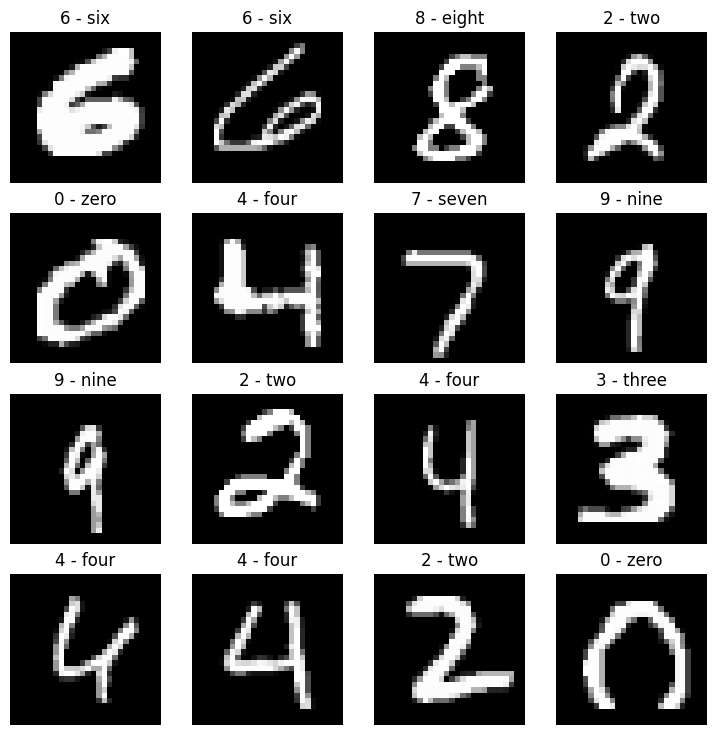

In [20]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [21]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [280]:
class MNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_layer_1(x)
        # print(x.shape)
        x = self.conv_layer_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [281]:
model_0_cpu = MNISTModelV0(input_shape=1, # Only 1 color channel
                           hidden_units=10,
                           output_shape=len(class_names)).cpu()

if Path("modelsEs/CpuMNISTModelV0.pth").is_file():
    model_0_cpu.load_state_dict(torch.load("modelsEs/CpuMNISTModelV0.pth"))
    print("Model Loaded Successfully!")
next(model_0_cpu.parameters()).device

Model Loaded Successfully!


/tmp/ipykernel_106790/3468867228.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0_cpu.load_state_dict(torch.load("modelsEs/CpuMNISTModelV0.pth"))


device(type='cpu')

In [283]:
img, label = train_data[0][0], train_data[0][1]
model_0_cpu.eval()
with torch.inference_mode():
    y_log = model_0_cpu(img.unsqueeze(dim=0).cpu())
y_log

tensor([[-6.1416, -5.0609, -5.7167, 12.5430, -8.7925, 18.1138, -6.8049, -1.6674,
          1.3996,  4.5502]])

In [213]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples.")
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc * 100:.2f}%")

def test_step(model: nn.Module, 
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc * 100:.2f}%\n")

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0_cpu.parameters(),
                             lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).cpu()

In [35]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time"""
    total_time = end - start
    print(f"Train on {device}: {total_time:.3f} seconds")
    return total_time

In [36]:
train_time_start_on_cpu = timer()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")

    train_step(model=model_0_cpu,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device="cpu")
    
    test_step(model=model_0_cpu,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device="cpu")
    
    print("=" * 40 + "\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0_cpu.parameters()).device))

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.26817 | Train Accuracy: 91.10%

Test Loss: 0.07595 | Test Accuracy: 97.62%

Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.06773 | Train Accuracy: 97.91%

Test Loss: 0.05992 | Test Accuracy: 97.88%

Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.05307 | Train Accuracy: 98.36%

Test Loss: 0.04801 | Test Accuracy: 98.39%

Epoch: 3
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.04646 | Train Accuracy: 98.56%

Test Loss: 0

In [ ]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device = device):
    
    loss, acc = 0, 0
    model.to(device)
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc.item() * 100}

In [288]:
model_0_cpu_results = eval_model(model=model_0_cpu,
                                 data_loader=test_dataloader,
                                 loss_fn=loss_fn,
                                 accuracy_fn=accuracy_fn.to(device),
                                 device=device)
model_0_cpu_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.038731563836336136,
 'model_acc': 98.67212176322937}

In [286]:
model_0_cuda = MNISTModelV0(input_shape=1, # Only 1 color channel
                           hidden_units=24,
                           output_shape=len(class_names)).to(device)

if Path("modelsEs/CudaMNISTModelV0.pth").is_file():
    model_0_cuda.load_state_dict(torch.load("modelsEs/CudaMNISTModelV0.pth"))
    print("Model Loaded Successfully!")
next(model_0_cuda.parameters()).device

Model Loaded Successfully!


/tmp/ipykernel_106790/2318260046.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0_cuda.load_state_dict(torch.load("modelsEs/CudaMNISTModelV0.pth"))


device(type='cuda', index=0)

In [218]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0_cuda.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [219]:
train_time_start_on_cuda = timer()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")

    train_step(model=model_0_cuda,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_0_cuda,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
    print("=" * 40 + "\n")

train_time_end_on_cuda = timer()
total_train_time_model_0_cuda = print_train_time(start=train_time_start_on_cuda,
                                            end=train_time_end_on_cuda,
                                            device=str(next(model_0_cuda.parameters()).device))

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.34298 | Train Accuracy: 88.38%
Test Loss: 0.07179 | Test Accuracy: 97.73%


Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.06752 | Train Accuracy: 97.88%
Test Loss: 0.04998 | Test Accuracy: 98.34%


Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.05086 | Train Accuracy: 98.39%
Test Loss: 0.04275 | Test Accuracy: 98.46%


Epoch: 3
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.04306 | Train Accuracy: 98.67%
Test Loss: 0.

In [287]:
model_0_cuda_results = eval_model(model=model_0_cuda,
                                 data_loader=test_dataloader,
                                 loss_fn=loss_fn,
                                 accuracy_fn=accuracy_fn.to(device),
                                 device=device)
model_0_cuda_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.036409929394721985,
 'model_acc': 98.80191683769226}

In [221]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)

            pred_probs.append(torch.softmax(pred_logit.squeeze(), dim=0).cpu())
    return torch.stack(pred_probs)

In [222]:
def get_random_samples(data: list, seed: int = None):
    random.seed(seed)
    test_samples = []
    test_labels = []

    for sample, label in random.sample(list(data), k=9):
        test_samples.append(sample)
        test_labels.append(label)
    return test_samples, test_labels

In [223]:
def plot_predictions(model: nn.Module,
                     data: list,
                     seed: int = None,
                     device: torch.device = device):
    
    test_samples, test_labels = get_random_samples(data=data, seed=seed)

    pred_classes = make_predictions(model=model, data=test_samples, device=device).argmax(dim=1)

    plt.figure(figsize=(10, 10))
    nrows = 3
    ncols = 3
    for i, sample in enumerate(test_samples):
        plt.subplot(nrows, ncols, i + 1)

        plt.imshow(sample.squeeze(), cmap="gray")

        pred_label = class_names[pred_classes[i]]
        true_label = class_names[test_labels[i]]

        plt.title(f"Pred: {pred_label} | True: {true_label}", c="g" if pred_label == true_label else "r")
        plt.axis(False)

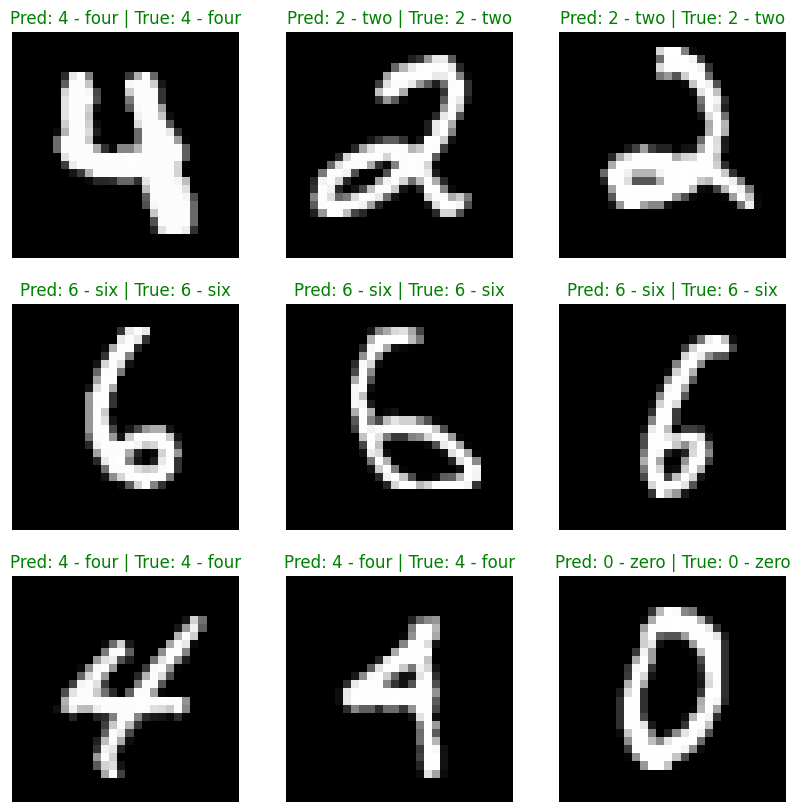

In [264]:
plot_predictions(model=model_0_cuda, data=test_data, seed=None)

In [289]:
# 1. Create models directory 
MODEL_PATH = Path("modelsEs")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "CpuMNISTModelV0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0_cpu.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: modelsEs/CpuMNISTModelV0.pth


In [290]:
# 1. Create models directory 
MODEL_PATH = Path("modelsEs")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "CudaMNISTModelV0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0_cuda.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: modelsEs/CudaMNISTModelV0.pth
